In [16]:
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

### Get Data ###

In [ ]:
df_image = pd.read_csv('label_and_path.csv')
X_image = df_image[:770]['image_path'].values

df_meta = pd.read_csv('skin_data.csv')
X_meta = df_meta[:770].drop(columns=['target']).values

y = df_image[:770]['target'].values

### Split Data ###

In [40]:
# Split for images
X_train_image, X_val_test_image, y_train_image, y_val_test_image = train_test_split(X_image, y, test_size=0.3, stratify=y)
X_val_image, X_test_image, y_val_image, y_test_image = train_test_split(X_val_test_image, y_val_test_image, test_size=0.5, stratify=y_val_test_image)

# Split for metadata
X_train_meta, X_val_test_meta, y_train_meta, y_val_test_meta = train_test_split(X_meta, y, test_size=0.3, stratify=y)
X_val_meta, X_test_meta, y_val_meta, y_test_meta = train_test_split(X_val_test_meta, y_val_test_meta, test_size=0.5, stratify=y_val_test_meta)

In [41]:
def preprocess_combined(image_path, metadata, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (128, 128))
    image = tf.cast(image, tf.float32) / 255.0
    return (image, metadata), label

def create_combined_dataset(image_paths, metadata, labels, batch_size=32, shuffle=True):
    image_paths = tf.constant(image_paths)
    metadata = tf.convert_to_tensor(metadata, dtype=tf.float32)
    labels = tf.convert_to_tensor(labels, dtype=tf.float32)

    ds = tf.data.Dataset.from_tensor_slices((image_paths, metadata, labels))
    ds = ds.map(preprocess_combined, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=1000)

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


In [42]:
train_ds = create_combined_dataset(X_train_image, X_train_meta, y_train_image, batch_size=256)
val_ds = create_combined_dataset(X_val_image, X_val_meta, y_val_image, batch_size=256, shuffle=False)
test_ds = create_combined_dataset(X_test_image, X_test_meta, y_test_image, batch_size=256, shuffle=False)

### CNN + MLP ###

In [43]:

# CNN Model
def CNN_model(input_shape=(128, 128, 3)):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Fine-tune the base model
    base_model.trainable = True
    
    # Define additional layers for your specific task
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    # Create model
    model = models.Model(inputs=base_model.input, outputs=output, name='cnn_model')
    
    return model


# MLP Model
def MLP_model(input_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(df_meta.shape[1], activation='relu')(x)
    
    return models.Model(inputs=inputs, outputs=x, name='metadata_model')


# Combined Model
def build_combined_model(image_shape, metadata_dim):
    cnn_model = CNN_model(image_shape)
    mlp_model = MLP_model(metadata_dim)

    # Flatten the CNN output to make it 2D
    cnn_flattened = layers.Flatten()(cnn_model.output)

    # Fusion
    combined = layers.concatenate([cnn_flattened, mlp_model.output])
    x = layers.Dense(64, activation='relu')(combined)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(1, activation='sigmoid')(x)  # Connect the output layer to `x`

    model = models.Model(inputs=[cnn_model.input, mlp_model.input], outputs=output)
    return model

In [44]:
model = build_combined_model(image_shape=(128, 128, 3), metadata_dim=X_train_meta.shape[1])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping_callback]
)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 93s 9s/step - accuracy: 0.4907 - loss: 40.3872 - val_accuracy: 0.4696 - val_loss: 9.0283
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.5143 - loss: 25.5693 - val_accuracy: 0.4783 - val_loss: 14.0918
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.5062 - loss: 30.3737 - val_accuracy: 0.4348 - val_loss: 6.0343
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step - accuracy: 0.4753 - loss: 22.4620 - val_accuracy: 0.4870 - val_loss: 5.0048
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.5154 - loss: 19.7739 - val_accuracy: 0.4957 - val_loss: 7.4915
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.4727 - loss: 18.9486 - val_accuracy: 0.4957 - val_loss: 5.6494
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.4925 - loss: 16.3015 - val_accuracy: 0.5304 - val_loss: 1.9090
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.4509 - loss: 16.8230 - val_accuracy: 0.5304 - val_loss: 2.0066

In [ ]:
# model.save('combined_model_58.keras')

In [45]:
test_probs = model.predict(test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [46]:
test_probs = np.array(test_probs).flatten()

In [47]:
print(test_probs[test_probs > 0.5])

[0.68650675 0.51438534 0.5343026  0.7261719  0.9573077  0.5350053
 0.890648   0.5627624  0.968728   0.98385143 0.7489443  0.8809349
 0.834151   0.545375   0.8759267  0.88130254 0.85797876 0.9983871
 0.82740355 0.6762918  0.59800977 0.75909746 0.85925955 0.5635553
 0.8260202  0.9639528  0.75168854 0.94149905 0.8891597  0.65833116
 0.7964281  0.8879004  0.71908635 0.8223877  0.94531476 0.68593264
 0.82814896 0.70267546 0.7426964  0.7686218  0.72470766 0.8411889
 0.89093107 0.83293223 0.72072136 0.56068695 0.6285874  0.5486208
 0.7710248  0.7858809  0.84597063 0.74649525 0.96837103 0.80163723
 0.5634396  0.9020228  0.6344831  0.9335139  0.79059184 0.8634114
 0.57554936 0.6248599  0.7959917  0.80785614 0.53169346 0.69568974
 0.8405049  0.9247073  0.8528414  0.9833194  0.67349505 0.6426542 ]


In [48]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step - accuracy: 0.4569 - loss: 1.0063
Test Loss: 1.0062956809997559
Test Accuracy: 0.4568965435028076


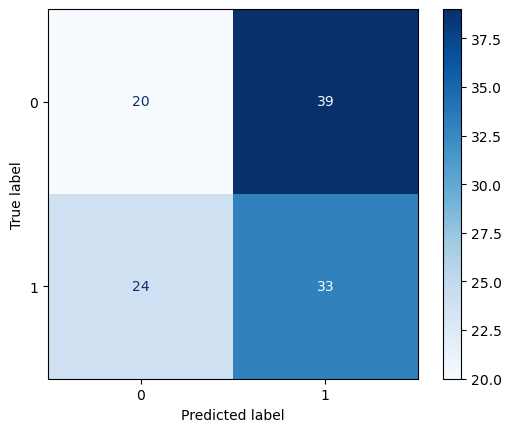

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming test_probs contains the predicted probabilities, we convert them to binary predictions
y_pred = (test_probs > 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_test_image, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')

### Auto Encoder ###

In [32]:
class ConvVAE(tf.keras.Model):
    def __init__(self, latent_dim=64):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder_conv = tf.keras.Sequential([
            layers.InputLayer(input_shape=(128, 128, 3)),
            layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
            layers.Conv2D(64, 3, strides=2, padding='same', activation='relu'),
            layers.Conv2D(128, 3, strides=2, padding='same', activation='relu'),
        ])
        self.flatten = layers.Flatten()
        self.fc_mu = layers.Dense(latent_dim)
        self.fc_logvar = layers.Dense(latent_dim)

        # Decoder
        self.decoder_fc = layers.Dense(16 * 16 * 64, activation='relu')  # adjust to match encoder output
        self.reshape_layer = layers.Reshape((16, 16, 64))
        self.decoder_deconv = tf.keras.Sequential([
            layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(3, 3, strides=2, padding='same', activation='sigmoid'),
        ])

    def encode(self, x):
        x = self.encoder_conv(x)
        x = self.flatten(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        eps = tf.random.normal(shape=tf.shape(mu))
        std = tf.exp(0.5 * logvar)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_fc(z)
        x = self.reshape_layer(x)
        return self.decoder_deconv(x)

    def call(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

    def compute_loss(self, x, x_recon, mu, logvar):
        # Reconstruction loss (MSE)
        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - x_recon), axis=[1, 2, 3]))
        # KL divergence
        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + logvar - tf.square(mu) - tf.exp(logvar), axis=1))
        return recon_loss + kl_loss

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]  # discard labels if present

        with tf.GradientTape() as tape:
            x_recon, mu, logvar = self(data, training=True)
            loss = self.compute_loss(data, x_recon, mu, logvar)

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return {"loss": loss}

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]  # discard labels if present

        x_recon, mu, logvar = self(data, training=False)
        loss = self.compute_loss(data, x_recon, mu, logvar)
        return {"val_loss": loss}

In [ ]:
vae = ConvVAE(latent_dim=64)
vae.compile(optimizer=tf.keras.optimizers.Adam())

early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

vae_train_ds = train_ds.map(lambda x, y: x[0])
vae_val_ds = val_ds.map(lambda x, y: x[0])
vae_test_ds = test_ds.map(lambda x, y: x[0])

vae.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1,
    callbacks=[early_stop]
)

c:\Users\travi\miniconda3\envs\cs178\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
c:\Users\travi\miniconda3\envs\cs178\lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_648
Received: inputs=('Tensor(shape=(None, 128, 128, 3))', 'Tensor(shape=(None, 58))')
  warnings.warn(msg)


ValueError: Shapes must be equal rank, but are 4 and 2
	From merging shape 0 with other shapes. for '{{node sub/x}} = Pack[N=2, T=DT_FLOAT, axis=0](data, data_1)' with input shapes: [?,128,128,3], [?,58].